# Policy/Pi-Value/Q-Adverserial/A gradients (PQA)


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [3]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    rewards = tf.placeholder(tf.float32, [None], name='rewards') # env rewards
    rewards2 = tf.placeholder(tf.float32, [None], name='rewards2') # actions logits rewards
    rewards3 = tf.placeholder(tf.float32, [None], name='rewards3') # actions labels rewards
    return states, actions, rewards, rewards2, rewards3

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [16]:
def model_loss(action_size, hidden_size, # model init
               states, actions, rewards, rewards2, rewards3): # model input for G & D 
    # policy learning/gradient
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    g_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                       labels=actions_labels))        
    
    #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    actions_probs = tf.nn.softmax(actions_logits)
    Qs2_logits = discriminator(actions=actions_probs, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    rewards2_logits = tf.nn.sigmoid(Qs2_logits) # total_rewards2
    #d_loss_fake = tf.reduce_mean(tf.square(Qs2_logits[:-1] - tf.reshape(rewards2[1:], shape=[-1, 1])))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
                                                                         labels=tf.reshape(rewards, shape=[-1, 1])))
    d_loss_fake += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits[:-1],
                                                                          labels=tf.reshape(rewards3[1:], 
                                                                                            shape=[-1, 1])))
    
    # Real or env or onehot encoded or label
    #actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs3_logits = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    rewards3_logits = tf.nn.sigmoid(Qs3_logits) # total_rewards3
    #d_loss_real += tf.reduce_mean(tf.square(Qs3_logits[:-1] - tf.reshape(rewards3[1:], shape=[-1, 1])))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits,
                                                                          labels=tf.reshape(rewards, shape=[-1, 1])))
    d_loss_real += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits[:-1],
                                                                          labels=tf.reshape(rewards3[1:], 
                                                                                            shape=[-1, 1])))
    d_loss_real += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
                                                                          labels=tf.zeros_like(tf.reshape(
                                                                              rewards, shape=[-1, 1]))))
    d_loss_real += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits[:-1],
                                                                          labels=tf.zeros_like(
                                                                              tf.reshape(rewards3[1:], shape=[-1, 1]))))
    
    # Returning/outputing actions, sum of rewards, rewards, and loss
    return actions_logits, rewards2_logits, rewards3_logits, g_loss, d_loss_fake, d_loss_real

In [17]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss_fake, d_loss_real, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss_fake: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param d_loss_real: Discriminator loss Tensor for reward prediction for env/onehot/labels action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss_real, var_list=d_vars)
        gd_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss_fake, var_list=g_vars)

    return g_opt, d_opt, gd_opt

In [18]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.rewards, self.rewards2, self.rewards3 = model_input(state_size=state_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.rewards2_logits, self.rewards3_logits, self.g_loss, self.d_loss_fake, self.d_loss_real = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init 
            actions=self.actions, states=self.states, # model input
            rewards=self.rewards, rewards2=self.rewards2, rewards3=self.rewards3) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt, self.gd_opt = model_opt(g_loss=self.g_loss, 
                                                        d_loss_fake=self.d_loss_fake,
                                                        d_loss_real=self.d_loss_real,
                                                        learning_rate=learning_rate)

In [19]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [20]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

In [31]:
# Now train with experiences
saver = tf.train.Saver()
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
saver = tf.train.Saver(var_list=d_vars)
# saver = tf.train.Saver(var_list=g_vars) # train D
# # saver = tf.train.Saver(var_list=t_vars)

# Env reward, action logits reward, action labels/onehot reward
rewards_list, rewards2_list, rewards3_list, g_loss_list, d_loss_fake_list, d_loss_real_list = [], [], [], [], [], []

# TF session for training
with tf.Session() as sess:
    
    # Rstoring/loading the trained/learned controller SA/SM
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-g.ckpt') 
    saver.restore(sess, 'checkpoints/model-g-d.ckpt') 
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    train_episodes = 1000
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0 # reward env
        total_reward2 = 0 # reward action logits
        total_reward3 = 0 # reward action onehot/labels

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits = sess.run([model.actions_logits],
                                     feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            #action *= 1-float(done)
            reward2, reward3 = sess.run([model.rewards2_logits, model.rewards3_logits],
                                        feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                   model.actions: np.array([action])})
            total_reward += reward # env
            total_reward2 += reward2[0, 0] #_action_logits
            total_reward3 += reward3[0, 0] #_actions_labels
            # state & action pair for policy learning: current policy/action
            # reward for adverserial/reward learning: current reward/value
            # reward2 and reward3 for value/Q learning: future rewards/value
            batch.append([state, action, reward, reward2[0, 0], reward3[0, 0]])
            state = next_state
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        rewards2 = np.array([each[3] for each in batch])
        rewards3 = np.array([each[4] for each in batch])
#         g_loss, _ = sess.run([model.g_loss, model.g_opt], 
#                              feed_dict = {model.states: states,
#                                           model.actions: actions})
#         d_loss_fake, _ = sess.run([model.d_loss_fake, model.gd_opt], 
#                              feed_dict = {model.states: states,
#                                           model.actions: actions, 
#                                           model.rewards:rewards, 
#                                           model.rewards2:rewards2, 
#                                           model.rewards3:rewards3})
#         d_loss_real, _ = sess.run([model.d_loss_real, model.d_opt], 
#                                      feed_dict = {model.states: states,
#                                                   model.actions: actions, 
#                                                   model.rewards:rewards, 
#                                                   model.rewards2:rewards2, 
#                                                   model.rewards3:rewards3})
        g_loss, d_loss_fake, d_loss_real, _ = sess.run([model.g_loss, 
                                                        model.d_loss_fake, 
                                                        model.d_loss_real, 
                                                        model.gd_opt], 
                                     feed_dict = {model.states: states,
                                                  model.actions: actions, 
                                                  model.rewards:rewards, 
                                                  model.rewards2:rewards2, 
                                                  model.rewards3:rewards3})
        print('Episode: {}'.format(ep),
              'total_reward: {}'.format(total_reward),
              'total_reward2: {:.4f}'.format(total_reward2),
              'total_reward3: {:.4f}'.format(total_reward3),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss_fake: {:.4f}'.format(d_loss_fake),
              'd_loss_real: {:.4f}'.format(d_loss_real))
        rewards_list.append([ep, total_reward])
        rewards2_list.append([ep, total_reward2])
        rewards3_list.append([ep, total_reward3])
        g_loss_list.append([ep, g_loss])
        d_loss_fake_list.append([ep, d_loss_fake])
        d_loss_real_list.append([ep, d_loss_real])
        
    # Save the trained/learned D using G/SM/SA
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-g-d2.ckpt')
    #saver.save(sess, tf.train.latest_checkpoint('checkpoints'))

INFO:tensorflow:Restoring parameters from checkpoints/model-g-d.ckpt
Episode: 0 total_reward: 9.0 total_reward2: 2.1589 total_reward3: 8.3005 g_loss: 0.5694 d_loss_fake: 12.5826 d_loss_real: 1.1421
Episode: 1 total_reward: 10.0 total_reward2: 2.9710 total_reward3: 9.3820 g_loss: 0.5290 d_loss_fake: 11.1478 d_loss_real: 1.6852
Episode: 2 total_reward: 9.0 total_reward2: 2.7226 total_reward3: 8.3656 g_loss: 0.4938 d_loss_fake: 11.3419 d_loss_real: 1.6940
Episode: 3 total_reward: 9.0 total_reward2: 2.9363 total_reward3: 8.3322 g_loss: 0.4595 d_loss_fake: 10.8466 d_loss_real: 1.9822
Episode: 4 total_reward: 10.0 total_reward2: 4.0437 total_reward3: 9.4292 g_loss: 0.4142 d_loss_fake: 9.2778 d_loss_real: 3.1133
Episode: 5 total_reward: 10.0 total_reward2: 4.2341 total_reward3: 9.4276 g_loss: 0.3863 d_loss_fake: 8.9831 d_loss_real: 3.4103
Episode: 6 total_reward: 9.0 total_reward2: 3.3534 total_reward3: 8.3128 g_loss: 0.3850 d_loss_fake: 9.9386 d_loss_real: 2.5439
Episode: 7 total_reward: 10.

Episode: 65 total_reward: 10.0 total_reward2: 9.0852 total_reward3: 9.3826 g_loss: 0.0041 d_loss_fake: 0.2868 d_loss_real: 9.5979
Episode: 66 total_reward: 9.0 total_reward2: 7.9224 total_reward3: 8.2556 g_loss: 0.0046 d_loss_fake: 0.3897 d_loss_real: 8.5610
Episode: 67 total_reward: 8.0 total_reward2: 7.1313 total_reward3: 7.3801 g_loss: 0.0040 d_loss_fake: 0.3374 d_loss_real: 8.0470
Episode: 68 total_reward: 9.0 total_reward2: 8.0479 total_reward3: 8.3349 g_loss: 0.0040 d_loss_fake: 0.3317 d_loss_real: 8.7572
Episode: 69 total_reward: 10.0 total_reward2: 9.2411 total_reward3: 9.4528 g_loss: 0.0030 d_loss_fake: 0.2301 d_loss_real: 9.8885
Episode: 70 total_reward: 10.0 total_reward2: 9.2202 total_reward3: 9.4451 g_loss: 0.0032 d_loss_fake: 0.2379 d_loss_real: 9.8211
Episode: 71 total_reward: 10.0 total_reward2: 9.2012 total_reward3: 9.4328 g_loss: 0.0032 d_loss_fake: 0.2440 d_loss_real: 9.6208
Episode: 72 total_reward: 9.0 total_reward2: 7.9657 total_reward3: 8.2502 g_loss: 0.0039 d_lo

Episode: 132 total_reward: 9.0 total_reward2: 8.2748 total_reward3: 8.3536 g_loss: 0.0011 d_loss_fake: 0.2461 d_loss_real: 9.0643
Episode: 133 total_reward: 10.0 total_reward2: 9.3789 total_reward3: 9.4447 g_loss: 0.0010 d_loss_fake: 0.1925 d_loss_real: 9.9631
Episode: 134 total_reward: 9.0 total_reward2: 8.1635 total_reward3: 8.2599 g_loss: 0.0013 d_loss_fake: 0.2843 d_loss_real: 8.7093
Episode: 135 total_reward: 10.0 total_reward2: 9.2919 total_reward3: 9.3794 g_loss: 0.0012 d_loss_fake: 0.2175 d_loss_real: 9.6479
Episode: 136 total_reward: 9.0 total_reward2: 8.1779 total_reward3: 8.2711 g_loss: 0.0012 d_loss_fake: 0.2790 d_loss_real: 8.8355
Episode: 137 total_reward: 10.0 total_reward2: 9.3895 total_reward3: 9.4499 g_loss: 0.0009 d_loss_fake: 0.1894 d_loss_real: 10.0027
Episode: 138 total_reward: 8.0 total_reward2: 7.3112 total_reward3: 7.3796 g_loss: 0.0011 d_loss_fake: 0.2661 d_loss_real: 8.1440
Episode: 139 total_reward: 8.0 total_reward2: 7.3221 total_reward3: 7.3842 g_loss: 0.0

Episode: 197 total_reward: 10.0 total_reward2: 9.3186 total_reward3: 9.3641 g_loss: 0.0006 d_loss_fake: 0.2110 d_loss_real: 9.6553
Episode: 198 total_reward: 9.0 total_reward2: 8.3076 total_reward3: 8.3486 g_loss: 0.0006 d_loss_fake: 0.2368 d_loss_real: 9.0734
Episode: 199 total_reward: 10.0 total_reward2: 9.2558 total_reward3: 9.3051 g_loss: 0.0006 d_loss_fake: 0.2289 d_loss_real: 9.6688
Episode: 200 total_reward: 8.0 total_reward2: 7.1870 total_reward3: 7.2365 g_loss: 0.0007 d_loss_fake: 0.3143 d_loss_real: 7.8186
Episode: 201 total_reward: 8.0 total_reward2: 7.3232 total_reward3: 7.3610 g_loss: 0.0006 d_loss_fake: 0.2629 d_loss_real: 8.1055
Episode: 202 total_reward: 10.0 total_reward2: 9.4371 total_reward3: 9.4671 g_loss: 0.0005 d_loss_fake: 0.1790 d_loss_real: 9.8595
Episode: 203 total_reward: 9.0 total_reward2: 8.2916 total_reward3: 8.3364 g_loss: 0.0006 d_loss_fake: 0.2435 d_loss_real: 8.7935
Episode: 204 total_reward: 10.0 total_reward2: 9.3200 total_reward3: 9.3659 g_loss: 0.0

Episode: 265 total_reward: 9.0 total_reward2: 8.2843 total_reward3: 8.3122 g_loss: 0.0004 d_loss_fake: 0.2458 d_loss_real: 8.8714
Episode: 266 total_reward: 9.0 total_reward2: 8.1857 total_reward3: 8.2193 g_loss: 0.0004 d_loss_fake: 0.2785 d_loss_real: 8.7020
Episode: 267 total_reward: 10.0 total_reward2: 9.4238 total_reward3: 9.4426 g_loss: 0.0003 d_loss_fake: 0.1823 d_loss_real: 9.9380
Episode: 268 total_reward: 10.0 total_reward2: 9.4739 total_reward3: 9.4891 g_loss: 0.0003 d_loss_fake: 0.1689 d_loss_real: 10.0267
Episode: 269 total_reward: 10.0 total_reward2: 9.2801 total_reward3: 9.3107 g_loss: 0.0004 d_loss_fake: 0.2217 d_loss_real: 9.7275
Episode: 270 total_reward: 9.0 total_reward2: 8.2253 total_reward3: 8.2537 g_loss: 0.0004 d_loss_fake: 0.2643 d_loss_real: 8.8927
Episode: 271 total_reward: 10.0 total_reward2: 9.3385 total_reward3: 9.3650 g_loss: 0.0004 d_loss_fake: 0.2060 d_loss_real: 9.7057
Episode: 272 total_reward: 10.0 total_reward2: 9.4171 total_reward3: 9.4372 g_loss: 0

Episode: 334 total_reward: 10.0 total_reward2: 9.4226 total_reward3: 9.4354 g_loss: 0.0002 d_loss_fake: 0.1835 d_loss_real: 9.8518
Episode: 335 total_reward: 10.0 total_reward2: 9.4005 total_reward3: 9.4144 g_loss: 0.0002 d_loss_fake: 0.1892 d_loss_real: 9.8321
Episode: 336 total_reward: 8.0 total_reward2: 7.3500 total_reward3: 7.3637 g_loss: 0.0002 d_loss_fake: 0.2536 d_loss_real: 8.1934
Episode: 337 total_reward: 9.0 total_reward2: 8.3228 total_reward3: 8.3384 g_loss: 0.0002 d_loss_fake: 0.2348 d_loss_real: 8.8296
Episode: 338 total_reward: 9.0 total_reward2: 8.3877 total_reward3: 8.4008 g_loss: 0.0002 d_loss_fake: 0.2140 d_loss_real: 9.0255
Episode: 339 total_reward: 10.0 total_reward2: 9.3112 total_reward3: 9.3300 g_loss: 0.0003 d_loss_fake: 0.2154 d_loss_real: 9.4347
Episode: 340 total_reward: 9.0 total_reward2: 8.4066 total_reward3: 8.4176 g_loss: 0.0002 d_loss_fake: 0.2074 d_loss_real: 9.1686
Episode: 341 total_reward: 9.0 total_reward2: 8.1951 total_reward3: 8.2151 g_loss: 0.00

Episode: 399 total_reward: 10.0 total_reward2: 9.3591 total_reward3: 9.3710 g_loss: 0.0002 d_loss_fake: 0.1996 d_loss_real: 9.8978
Episode: 400 total_reward: 9.0 total_reward2: 8.3575 total_reward3: 8.3674 g_loss: 0.0001 d_loss_fake: 0.2212 d_loss_real: 9.2044
Episode: 401 total_reward: 10.0 total_reward2: 9.3711 total_reward3: 9.3825 g_loss: 0.0001 d_loss_fake: 0.1970 d_loss_real: 9.8515
Episode: 402 total_reward: 10.0 total_reward2: 9.3742 total_reward3: 9.3859 g_loss: 0.0002 d_loss_fake: 0.1970 d_loss_real: 9.7166
Episode: 403 total_reward: 8.0 total_reward2: 7.3108 total_reward3: 7.3211 g_loss: 0.0002 d_loss_fake: 0.2678 d_loss_real: 8.0971
Episode: 404 total_reward: 10.0 total_reward2: 9.3541 total_reward3: 9.3656 g_loss: 0.0002 d_loss_fake: 0.2024 d_loss_real: 9.6695
Episode: 405 total_reward: 10.0 total_reward2: 9.2899 total_reward3: 9.3037 g_loss: 0.0002 d_loss_fake: 0.2198 d_loss_real: 9.6421
Episode: 406 total_reward: 8.0 total_reward2: 7.2933 total_reward3: 7.3043 g_loss: 0.

Episode: 465 total_reward: 9.0 total_reward2: 8.3802 total_reward3: 8.3869 g_loss: 0.0001 d_loss_fake: 0.2170 d_loss_real: 8.9480
Episode: 466 total_reward: 9.0 total_reward2: 8.2883 total_reward3: 8.2973 g_loss: 0.0001 d_loss_fake: 0.2441 d_loss_real: 8.9375
Episode: 467 total_reward: 10.0 total_reward2: 9.3784 total_reward3: 9.3865 g_loss: 0.0001 d_loss_fake: 0.1950 d_loss_real: 9.8538
Episode: 468 total_reward: 9.0 total_reward2: 8.3552 total_reward3: 8.3623 g_loss: 0.0001 d_loss_fake: 0.2237 d_loss_real: 9.0384
Episode: 469 total_reward: 10.0 total_reward2: 9.4375 total_reward3: 9.4438 g_loss: 0.0001 d_loss_fake: 0.1797 d_loss_real: 9.8754
Episode: 470 total_reward: 9.0 total_reward2: 8.3350 total_reward3: 8.3434 g_loss: 0.0001 d_loss_fake: 0.2303 d_loss_real: 8.9249
Episode: 471 total_reward: 10.0 total_reward2: 9.4334 total_reward3: 9.4392 g_loss: 0.0001 d_loss_fake: 0.1801 d_loss_real: 9.9577
Episode: 472 total_reward: 8.0 total_reward2: 7.3715 total_reward3: 7.3774 g_loss: 0.00

Episode: 529 total_reward: 10.0 total_reward2: 9.4444 total_reward3: 9.4485 g_loss: 0.0001 d_loss_fake: 0.1775 d_loss_real: 9.9673
Episode: 530 total_reward: 8.0 total_reward2: 7.3055 total_reward3: 7.3112 g_loss: 0.0001 d_loss_fake: 0.2694 d_loss_real: 8.1033
Episode: 531 total_reward: 9.0 total_reward2: 8.3349 total_reward3: 8.3406 g_loss: 0.0001 d_loss_fake: 0.2309 d_loss_real: 8.8769
Episode: 532 total_reward: 9.0 total_reward2: 8.3100 total_reward3: 8.3157 g_loss: 0.0001 d_loss_fake: 0.2379 d_loss_real: 8.9366
Episode: 533 total_reward: 8.0 total_reward2: 7.2980 total_reward3: 7.3038 g_loss: 0.0001 d_loss_fake: 0.2723 d_loss_real: 8.0529
Episode: 534 total_reward: 8.0 total_reward2: 7.3704 total_reward3: 7.3751 g_loss: 0.0001 d_loss_fake: 0.2470 d_loss_real: 8.2076
Episode: 535 total_reward: 9.0 total_reward2: 8.4023 total_reward3: 8.4066 g_loss: 0.0001 d_loss_fake: 0.2092 d_loss_real: 9.1146
Episode: 536 total_reward: 9.0 total_reward2: 8.2864 total_reward3: 8.2932 g_loss: 0.0001

Episode: 598 total_reward: 10.0 total_reward2: 9.4291 total_reward3: 9.4327 g_loss: 0.0001 d_loss_fake: 0.1830 d_loss_real: 9.7379
Episode: 599 total_reward: 10.0 total_reward2: 9.3977 total_reward3: 9.4017 g_loss: 0.0001 d_loss_fake: 0.1915 d_loss_real: 9.6712
Episode: 600 total_reward: 9.0 total_reward2: 8.3613 total_reward3: 8.3654 g_loss: 0.0001 d_loss_fake: 0.2220 d_loss_real: 9.0314
Episode: 601 total_reward: 8.0 total_reward2: 7.3186 total_reward3: 7.3223 g_loss: 0.0001 d_loss_fake: 0.2651 d_loss_real: 8.1172
Episode: 602 total_reward: 9.0 total_reward2: 8.3456 total_reward3: 8.3495 g_loss: 0.0001 d_loss_fake: 0.2272 d_loss_real: 8.9517
Episode: 603 total_reward: 8.0 total_reward2: 7.3294 total_reward3: 7.3329 g_loss: 0.0001 d_loss_fake: 0.2612 d_loss_real: 8.1419
Episode: 604 total_reward: 9.0 total_reward2: 8.2358 total_reward3: 8.2409 g_loss: 0.0001 d_loss_fake: 0.2606 d_loss_real: 8.8751
Episode: 605 total_reward: 10.0 total_reward2: 9.4577 total_reward3: 9.4607 g_loss: 0.00

Episode: 665 total_reward: 10.0 total_reward2: 9.3137 total_reward3: 9.3179 g_loss: 0.0001 d_loss_fake: 0.2145 d_loss_real: 9.5139
Episode: 666 total_reward: 9.0 total_reward2: 8.2999 total_reward3: 8.3037 g_loss: 0.0001 d_loss_fake: 0.2427 d_loss_real: 8.7396
Episode: 667 total_reward: 10.0 total_reward2: 9.4514 total_reward3: 9.4537 g_loss: 0.0000 d_loss_fake: 0.1745 d_loss_real: 10.1319
Episode: 668 total_reward: 10.0 total_reward2: 9.4251 total_reward3: 9.4277 g_loss: 0.0000 d_loss_fake: 0.1825 d_loss_real: 9.9455
Episode: 669 total_reward: 9.0 total_reward2: 8.3058 total_reward3: 8.3093 g_loss: 0.0000 d_loss_fake: 0.2383 d_loss_real: 9.0249
Episode: 670 total_reward: 8.0 total_reward2: 7.3436 total_reward3: 7.3464 g_loss: 0.0000 d_loss_fake: 0.2554 d_loss_real: 8.2343
Episode: 671 total_reward: 9.0 total_reward2: 8.4272 total_reward3: 8.4296 g_loss: 0.0000 d_loss_fake: 0.2031 d_loss_real: 9.0441
Episode: 672 total_reward: 11.0 total_reward2: 10.3406 total_reward3: 10.3447 g_loss: 

Episode: 733 total_reward: 9.0 total_reward2: 8.3079 total_reward3: 8.3109 g_loss: 0.0000 d_loss_fake: 0.2402 d_loss_real: 8.7339
Episode: 734 total_reward: 10.0 total_reward2: 9.4694 total_reward3: 9.4712 g_loss: 0.0000 d_loss_fake: 0.1713 d_loss_real: 9.9328
Episode: 735 total_reward: 10.0 total_reward2: 9.3999 total_reward3: 9.4022 g_loss: 0.0000 d_loss_fake: 0.1898 d_loss_real: 9.8036
Episode: 736 total_reward: 9.0 total_reward2: 8.2534 total_reward3: 8.2565 g_loss: 0.0000 d_loss_fake: 0.2548 d_loss_real: 8.9117
Episode: 737 total_reward: 9.0 total_reward2: 8.2796 total_reward3: 8.2825 g_loss: 0.0000 d_loss_fake: 0.2471 d_loss_real: 8.9010
Episode: 738 total_reward: 10.0 total_reward2: 9.3781 total_reward3: 9.3806 g_loss: 0.0000 d_loss_fake: 0.1959 d_loss_real: 9.7605
Episode: 739 total_reward: 10.0 total_reward2: 9.3751 total_reward3: 9.3778 g_loss: 0.0000 d_loss_fake: 0.1973 d_loss_real: 9.6629
Episode: 740 total_reward: 9.0 total_reward2: 8.2552 total_reward3: 8.2581 g_loss: 0.0

Episode: 801 total_reward: 9.0 total_reward2: 8.3812 total_reward3: 8.3832 g_loss: 0.0000 d_loss_fake: 0.2161 d_loss_real: 9.0350
Episode: 802 total_reward: 9.0 total_reward2: 8.3090 total_reward3: 8.3111 g_loss: 0.0000 d_loss_fake: 0.2381 d_loss_real: 8.9624
Episode: 803 total_reward: 10.0 total_reward2: 9.4512 total_reward3: 9.4527 g_loss: 0.0000 d_loss_fake: 0.1758 d_loss_real: 9.9651
Episode: 804 total_reward: 9.0 total_reward2: 8.3218 total_reward3: 8.3239 g_loss: 0.0000 d_loss_fake: 0.2344 d_loss_real: 8.9300
Episode: 805 total_reward: 9.0 total_reward2: 8.3484 total_reward3: 8.3502 g_loss: 0.0000 d_loss_fake: 0.2249 d_loss_real: 9.1246
Episode: 806 total_reward: 10.0 total_reward2: 9.3213 total_reward3: 9.3238 g_loss: 0.0000 d_loss_fake: 0.2130 d_loss_real: 9.4665
Episode: 807 total_reward: 9.0 total_reward2: 8.3884 total_reward3: 8.3900 g_loss: 0.0000 d_loss_fake: 0.2129 d_loss_real: 9.1854
Episode: 808 total_reward: 10.0 total_reward2: 9.4354 total_reward3: 9.4370 g_loss: 0.00

Episode: 871 total_reward: 10.0 total_reward2: 9.4096 total_reward3: 9.4110 g_loss: 0.0000 d_loss_fake: 0.1872 d_loss_real: 9.8436
Episode: 872 total_reward: 9.0 total_reward2: 8.3954 total_reward3: 8.3969 g_loss: 0.0000 d_loss_fake: 0.2128 d_loss_real: 8.9569
Episode: 873 total_reward: 9.0 total_reward2: 8.3125 total_reward3: 8.3144 g_loss: 0.0000 d_loss_fake: 0.2387 d_loss_real: 8.7555
Episode: 874 total_reward: 8.0 total_reward2: 7.2078 total_reward3: 7.2098 g_loss: 0.0000 d_loss_fake: 0.3073 d_loss_real: 7.7856
Episode: 875 total_reward: 11.0 total_reward2: 10.3773 total_reward3: 10.3790 g_loss: 0.0000 d_loss_fake: 0.1790 d_loss_real: 10.4830
Episode: 876 total_reward: 9.0 total_reward2: 8.2585 total_reward3: 8.2605 g_loss: 0.0000 d_loss_fake: 0.2543 d_loss_real: 8.8028
Episode: 877 total_reward: 9.0 total_reward2: 8.2948 total_reward3: 8.2966 g_loss: 0.0000 d_loss_fake: 0.2422 d_loss_real: 8.9622
Episode: 878 total_reward: 11.0 total_reward2: 10.4090 total_reward3: 10.4104 g_loss:

Episode: 938 total_reward: 9.0 total_reward2: 8.3977 total_reward3: 8.3988 g_loss: 0.0000 d_loss_fake: 0.2108 d_loss_real: 9.1282
Episode: 939 total_reward: 9.0 total_reward2: 8.2801 total_reward3: 8.2816 g_loss: 0.0000 d_loss_fake: 0.2473 d_loss_real: 8.8978
Episode: 940 total_reward: 9.0 total_reward2: 8.2707 total_reward3: 8.2724 g_loss: 0.0000 d_loss_fake: 0.2505 d_loss_real: 8.8308
Episode: 941 total_reward: 8.0 total_reward2: 7.2882 total_reward3: 7.2896 g_loss: 0.0000 d_loss_fake: 0.2766 d_loss_real: 8.0135
Episode: 942 total_reward: 9.0 total_reward2: 8.3635 total_reward3: 8.3649 g_loss: 0.0000 d_loss_fake: 0.2224 d_loss_real: 8.9023
Episode: 943 total_reward: 10.0 total_reward2: 9.3824 total_reward3: 9.3836 g_loss: 0.0000 d_loss_fake: 0.1938 d_loss_real: 9.9034
Episode: 944 total_reward: 8.0 total_reward2: 7.2920 total_reward3: 7.2933 g_loss: 0.0000 d_loss_fake: 0.2749 d_loss_real: 8.0571
Episode: 945 total_reward: 10.0 total_reward2: 9.4672 total_reward3: 9.4681 g_loss: 0.000

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total env rewards')

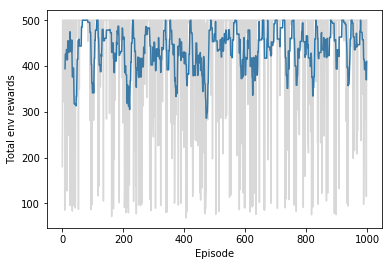

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total env rewards')

Text(0,0.5,'Total actions logits rewards')

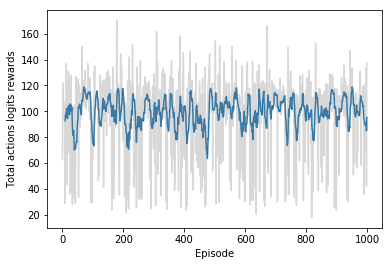

In [25]:
eps, arr = np.array(rewards2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total actions logits rewards')

Text(0,0.5,'Total actions labels/onehot rewards')

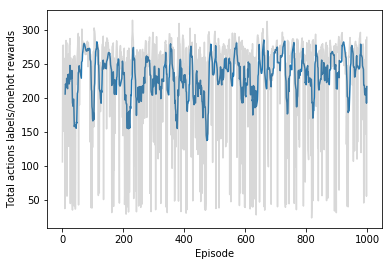

In [26]:
eps, arr = np.array(rewards3_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total actions labels/onehot rewards')

Text(0,0.5,'Gloss')

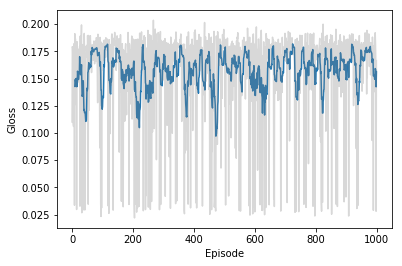

In [27]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Gloss')

Text(0,0.5,'Dloss')

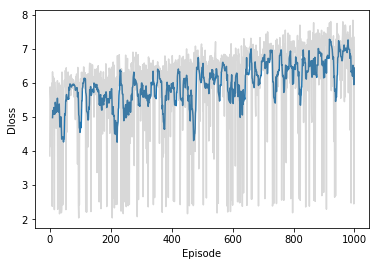

In [28]:
eps, arr = np.array(d_loss_fake_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Dloss')

Text(0,0.5,'Dloss')

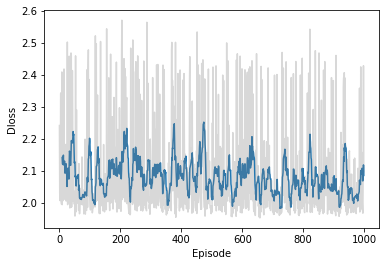

In [29]:
eps, arr = np.array(d_loss_real_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Dloss')